# Social Computing/Social Gaming - Summer 2025
# Exercise Sheet 3 - Clustering in Dating App

Clustering aims at grouping data-points according to certain characteristics of interest. The groupings aim to achieve intra-cluster cohesion and inter-cluster de-cohesion. In this exercise, we will make a clustering with the users of the dating app OkCupid dataset, trying to find potential partners for a particular user.

The dating app dataset offers a unique insight into the ways people present themselves in the search for companionship or love. Clustering, a fundamental technique in **unsupervised machine learning**, allows us to navigate this complex data by grouping users based on shared characteristics. By identifying these groups, we can better understand user dynamics, tailor experiences, and even predict preferences, thereby enhancing the efficacy of the dating app.

## Import needed libraries for assignment

In [1]:
# Import all the libraries
import numpy as np
import re
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Task 3.1 - Exploratory Data Analysis
The [dataset](https://www.kaggle.com/datasets/andrewmvd/okcupid-profiles)[1] stands from the dating app OkCupid. The dataset consists of 59946 entries and 31 columns.
For our needs, the dataset was slightly modified to contain extra 5 columns: `city`, `state`, `likes_dogs`, `likes_cats` and `id` for easier manipulations later on.

#### Let's read the dataset "okcupid_profiles.csv". 
We will copy data to `df`, so we would always be able to reference the original one.

In [2]:
profiles = pd.read_csv('okcupid_profiles.csv')
df = profiles.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         59946 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

#### Let's perform an initial cleanup
**a)** **Remove** the 'drugs' column, which is not relevant for our clustering analysis, and rename the 'speaks' column to 'languages' for clearer semantics. 

In [3]:
# Remove `drugs` column and rename `speaks` to `languages` column

df.drop(columns=['drugs'], inplace=True)
df.rename(columns={'speaks': 'languages'}, inplace=True)

Here, we conduct an initial EDA (Exploratory Data Analysis) focusing on missing values. By identifying the columns with missing data and visualizing the count of missing values, we can make informed decisions on data imputation or cleanup.

In [4]:
isna_cols = df.loc[:, df.isna().any()].columns
missing_values = df[isna_cols[:12]].isna().sum().sort_values(ascending=False)

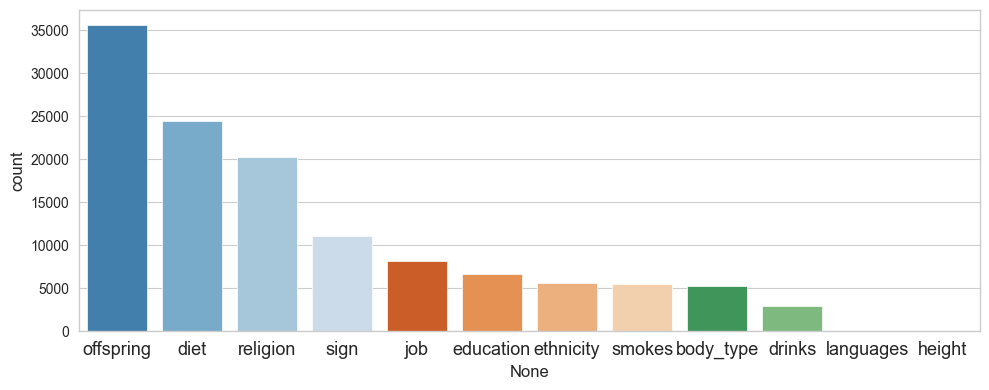

In [5]:
plt.style.use('ggplot')
sns.set_style("whitegrid")
fig0, ax0 = plt.subplots(figsize=(10,4))
sns.barplot(x=missing_values.index, y=missing_values, palette='tab20c', hue=missing_values.index, legend=False)
ax0.set(xticks=range(len(missing_values)), ylabel='count')
ax0.set_xticklabels(labels=missing_values.index, fontsize=13)
fig0.tight_layout()

**b)** **Address** missing values (`na`) in `age` and `height` columns by filling with the mean of each column.

In [ ]:
# fill missing values with the mean of the corresponding column
df['age'] = df['age'].fillna(df['age'].mean())
df['height'] = df['height'].fillna(df['height'].mean())

#### Visualization of Sex and Sexual Orientation Distribution
These visualizations are essential for gaining a clear understanding of the demographic composition of the user base.

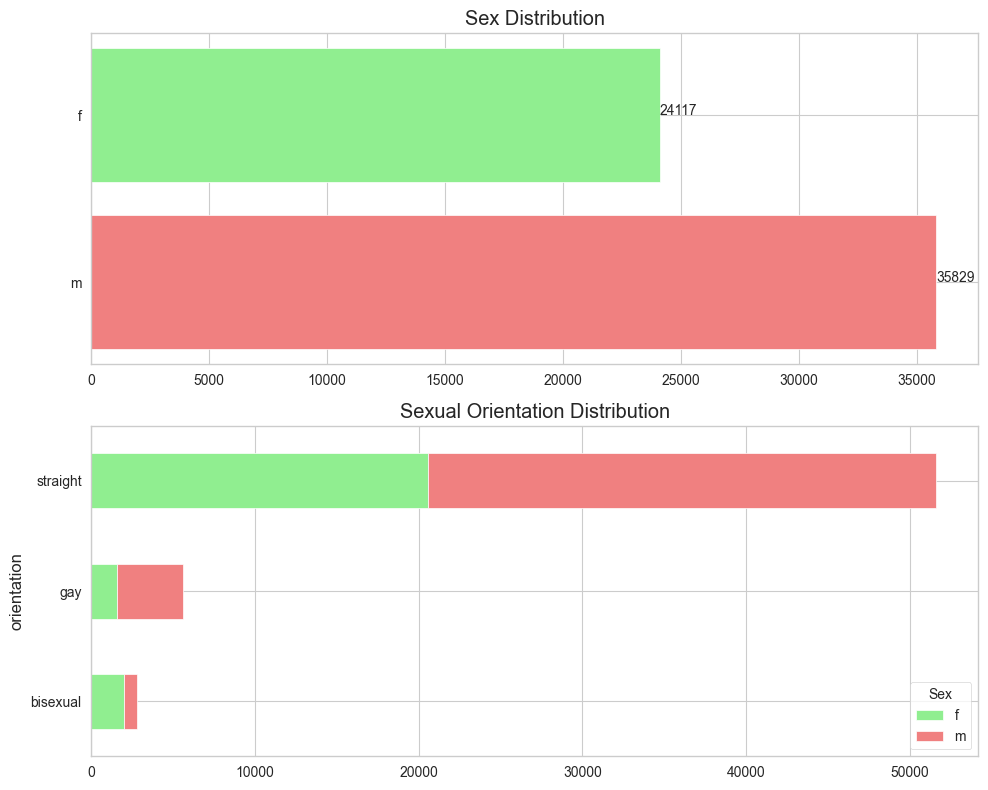

In [8]:
# Sex distribution, Orientation
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

sex_counts = df['sex'].value_counts()
ax[0].barh(sex_counts.index, sex_counts.values, color=['lightcoral', 'lightgreen'])
ax[0].set_title('Sex Distribution')
for index, value in enumerate(sex_counts.values):
    ax[0].text(value, index, str(value))

orientation_counts = df.groupby(['orientation', 'sex']).size().unstack().fillna(0)
orientation_counts.plot(kind='barh', stacked=True, ax=ax[1], color=['lightgreen', 'lightcoral'])
ax[1].set_title('Sexual Orientation Distribution')
ax[1].legend(title='Sex')

plt.tight_layout()
plt.show()

#### Visualizing preferences for pets
To explore user preferences regarding pets, we visualize the distribution of users' likings for dogs and cats across different genders.

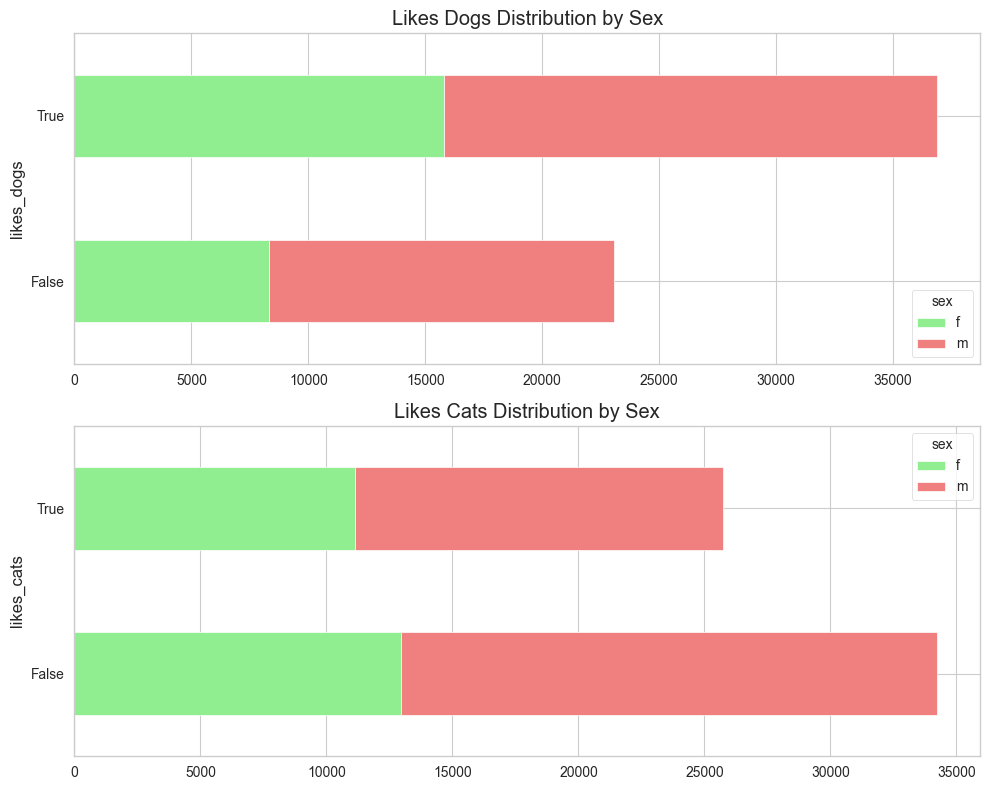

In [9]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

# Likes Dogs Distribution split by Sex
dog_likes_by_sex = df.groupby(['likes_dogs', 'sex']).size().unstack().fillna(0)
dog_likes_by_sex.plot(kind='barh', stacked=True, ax=ax[0], color=['lightgreen', 'lightcoral'])
ax[0].set_title('Likes Dogs Distribution by Sex')

# Likes Cats Distribution split by Sex
cat_likes_by_sex = df.groupby(['likes_cats', 'sex']).size().unstack().fillna(0)
cat_likes_by_sex.plot(kind='barh', stacked=True, ax=ax[1], color=['lightgreen', 'lightcoral'])
ax[1].set_title('Likes Cats Distribution by Sex')

plt.tight_layout()
plt.show()

#### Age Distribution by Sex
This side-by-side visualization facilitates easy comparison of age distributions between sexes, offering insights into demographic trends or preferences within the dating app's community.

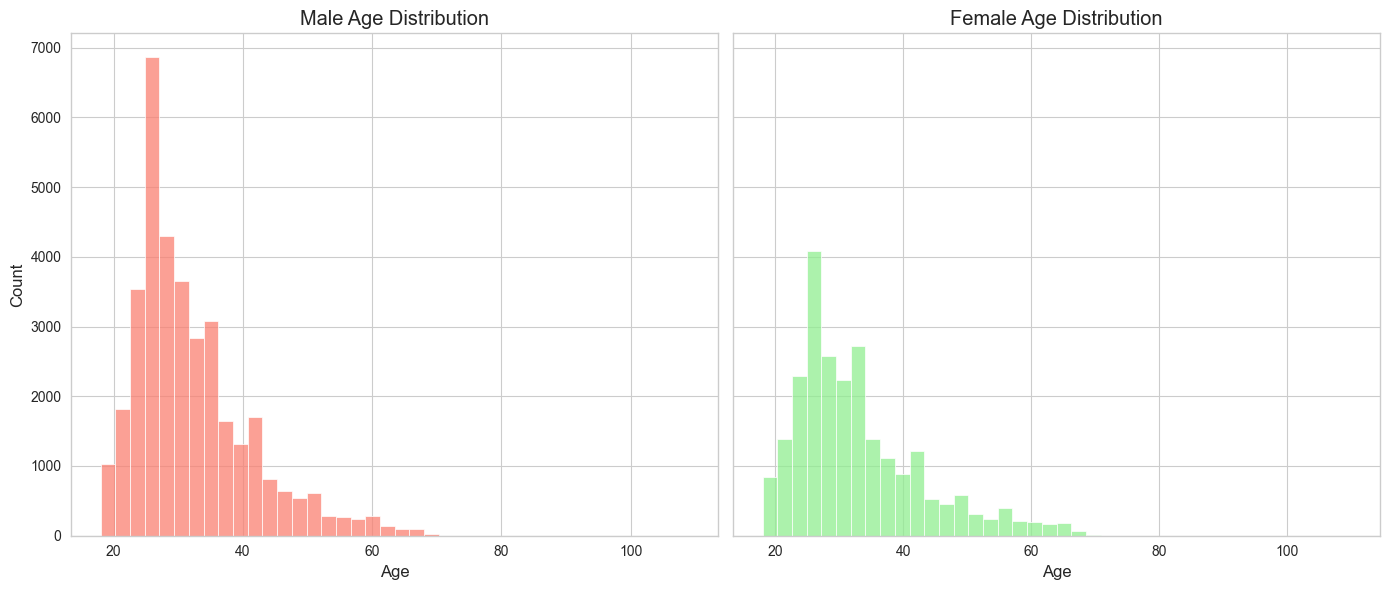

In [10]:
f, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Filter data by sex
males = df[df['sex'] == 'm']
females = df[df['sex'] == 'f']

# Plot for males
sns.histplot(males['age'], bins=40, ax=axes[0], color='salmon', kde=False)
axes[0].set_title('Male Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Plot for females
sns.histplot(females['age'], bins=40, ax=axes[1], color='lightgreen', kde=False)
axes[1].set_title('Female Age Distribution')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**c)** Based on dataset and the provided graphs, what general observations can be done about the users of the dating app? **Document** your observations here.

**Possible observations:**

In general, there are more men than women in the dataset. Regarding sexual orientation, the most common category is straight. Among gay users, men are more represented, while among bisexuals, women are slightly more common, although both categories have much fewer people overall.

When it comes to pet preferences, more men than women like dogs (though the proportions are quite close). Also, more men than women say they don’t like dogs.

The same trend appears with cats, but overall, more people like dogs than cats, and more people dislike cats than dislike dogs.

As for the age distribution, it shows a similar pattern for both men and women, with a peak around 23 years old and then an irregular decline.


## Task 3.2 - Convert data to categorical types
Since some columns contain a large range of unique values, we need to group values in smaller ranges and categorize them.

With this function, we will convert multiple answers to [ordered categorical types](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.CategoricalDtype.html) [3] for easier data manipulations, using an ad-hoc dictionary for each feature.

*Note: each handcrafted feature replaces the initial one.*

In [11]:
def map_cat(entry, dictionary):
    for k in dictionary:
        if entry in k:
            return dictionary.get(k)
    return np.NaN

**a)** **Print** each unique value from the `drinks` column with its count. Include `na` as well.

In [ ]:
# Print unique values with their counts from `drinks` column
print("Unique values in 'drinks' column with counts:")
print(df['drinks'].value_counts(dropna =False))

Unique values in 'drinks' column with counts:
drinks
socially       41780
rarely          5957
often           5164
not at all      3267
NaN             2985
very often       471
desperately      322
Name: count, dtype: int64


Having a vizualization of all unique values, we can create a mapping dictionary for all unique answers from `drinks` column, so that in the end there are only 3 categories. We convert the existing data entries to our new categories and save it in the same column.

In [13]:
# Create a mapping dictionary
drinks_dic = {('not at all',):'no',
             ('rarely', 'socially'):'sometimes',
              ('often', 'very often', 'desperately'):'yes'}
# Create categories for mapping
drinks_categories = CategoricalDtype(categories=['no', 'sometimes', 'yes'],ordered=True)
# Covert data
df['drinks'] = df.drinks.apply(map_cat, args=(drinks_dic,)).astype(drinks_categories)
# Fill na with `no` to avoid empty data
df.drinks = df.drinks.fillna('no').astype(drinks_categories)

**b)** Now we will repeat the same process done to `drinks` to the values of `smokes`. **Print** each unique value from the `smokes` column with its count. Include `na` as well.

In [14]:
# TODO: Print unique values with their counts of `smokes` column
print("Unique values in 'smokes' column with counts:")
print(df['smokes'].value_counts(dropna=False))

Unique values in 'smokes' column with counts:
smokes
no                43896
NaN                5512
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: count, dtype: int64


**Create** a mapping dictionary for all unique answers from column `smokes`, so there are only 3 categories: `no`, `sometimes`, `yes`. Then, convert the existing data to our new categories and save it in the same column. 

In [16]:
# Group `smokes` entries in fewer categories
smokes_dic = {('no',):'no', 
              ('sometimes', 'trying to quiit', 'when drinking'):'sometimes',
              ('yes',):'yes'}

# Create categories for mapping
smoke_categories = CategoricalDtype(categories=['no', 'sometimes', 'yes'],ordered=True)
# Covert data
df['smokes'] = df.smokes.apply(map_cat, args=(smokes_dic,)).astype(smoke_categories)
# Fill na with `no` to avoid empty data
df.smokes = df.smokes.fillna('no').astype(smoke_categories)

Here we visualize new data distribution with each now containing 3 categories: "yes", "sometimes", "often".

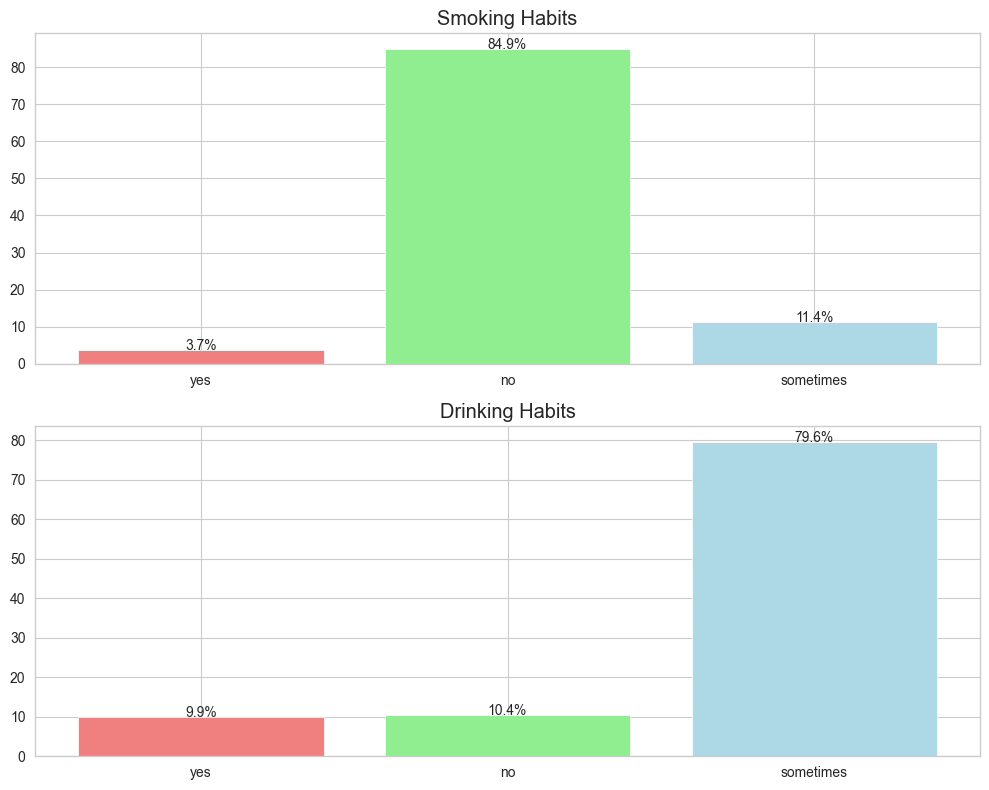

In [17]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

# 'smokes' distribution split by 'yes', 'no', 'sometimes'
smokes_counts = df['smokes'].value_counts(normalize=True).reindex(['yes', 'no', 'sometimes']).fillna(0) * 100
ax[0].bar(smokes_counts.index, smokes_counts.values, color=['lightcoral', 'lightgreen', 'lightblue'])
ax[0].set_title('Smoking Habits')
for index, value in enumerate(smokes_counts.values):
    ax[0].text(index, value, f'{value:.1f}%', ha='center')

# 'drinks' distribution split by 'yes', 'no', 'sometimes'
drinks_counts = df['drinks'].value_counts(normalize=True).reindex(['yes', 'no', 'sometimes']).fillna(0) * 100
ax[1].bar(drinks_counts.index, drinks_counts.values, color=['lightcoral', 'lightgreen', 'lightblue'])
ax[1].set_title('Drinking Habits')
for index, value in enumerate(drinks_counts.values):
    ax[1].text(index, value, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()


## Task 3.3 - Clustering Users

We can use a clustering algorithm in order to form groups of users with affinity. In this case we are going to apply [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) [4] and [GMM](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) [5] clustering methods utilizing scikit-learn.

### Feature preparation
Initially, we select a set of features ['age', 'height', 'education', 'drinks', 'smokes', 'diet', 'likes_dogs', 'likes_cats', 'city', 'state'] believed to influence user compatibility. The first two features are numerical, while the others are categorical.
Categorical features should be converted to numerical codes because clustering algorithms require numerical input. This step is crucial for incorporating categorical data into our analysis.

In [18]:
features = ['age', 'height', 'education', 'drinks', 'smokes', 'diet', 'likes_dogs', 'likes_cats', 'city', 'state']

In [19]:
X = df[features[0:2]].copy()
X.head()

,age,height
0,22,75.0
1,35,70.0
2,38,68.0
3,23,71.0
4,29,66.0


In [20]:
for feat in features[2:]:  # features[2:] are supposed to be categorical
    if not isinstance(df[feat].dtype, pd.CategoricalDtype): 
        df[feat] = df[feat].astype('category')  
    X[feat] = df[feat].cat.codes  
    
# After conversion, check for null values
X.isnull().sum()

age           0
height        0
education     0
drinks        0
smokes        0
diet          0
likes_dogs    0
likes_cats    0
city          0
state         0
dtype: int64

Great! Now we have all the features of interest as numerical values.

### Data Normalization

**a)** **Apply** [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) [2] to normalize the features set `X`, ensuring that each category contributes equally to the distance calculations during clustering. 

Please, set the scaler output to `transform = 'pandas'`. Save normalized data as `X_scaled`.

In [21]:
# Normalize the data with StandartScaler
scaler = StandardScaler().set_output(transform="pandas")
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [22]:
print(X_scaled.head())

        age    height  education    drinks    smokes      diet  likes_dogs  \
0 -1.093898  1.678416   1.555569  0.010905  1.702535  1.702091    0.791039   
1  0.281370  0.426749   2.306299  2.226885 -0.395008  0.789558    0.791039   
2  0.598740 -0.073919   0.054108  0.010905 -0.395008 -0.579242   -1.264160   
3 -0.988108  0.677082   1.555569  0.010905 -0.395008  3.299024   -1.264160   
4 -0.353369 -0.574586  -0.321258  0.010905 -0.395008 -0.807376    0.791039   

   likes_cats      city     state  
0    1.153409  0.986468 -0.033556  
1    1.153409 -0.191146 -0.033556  
2    1.153409  0.573270 -0.033556  
3    1.153409 -2.277796 -0.033556  
4    1.153409  0.573270 -0.033556  


### Applying Clustering Algorithms

We use K-Means and Gaussian Mixture Model (GMM) clustering algorithms to segment the users. K-Means is straightforward and efficient for spherical clusters, while GMM accommodates clusters with different shapes and sizes, providing flexibility in capturing the structure of the data.

In [24]:
n_clusters = 12

**b)** **Create** kmeans clustering model with `random_state=42` and `n_init=10` and provided number of clusters. Also, generate kmeans labels of `X_scaled`

In [25]:
# K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

**c)** **Create** GMM clustering model with `random_state=42` and provided number of clusters. Also, generate gmm labels of `X_scaled`

In [26]:
# Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

Each user is now assigned a cluster label, indicating their membership in one of the formed clusters.

In [27]:
df['kmeans_cluster'] = kmeans_labels
df['gmm_cluster'] = gmm_labels

### Visualization of Clusters

To understand the spatial distribution of clusters, we reduce the dimensionality of the data using PCA and t-SNE, two techniques that project high-dimensional data onto a 2D plane. This step helps visualize the separation between clusters.

**Note: It will take some time to plot these graphs, in specific the t-SNE vizualization. You can adjust the number of entries used in the graphs by modifying `n` and running the code below. Naturally, this will simplify the cluster visualization by reducing the amount of data and will affect the next task when finding a potential match.**

In [50]:
# Number of first n entries to be used in the analysis. You can set n = 59946 to use all data available
# Alter n to reduce data
n = 20000

X_scaled_reduced = X_scaled.head(n)
kmeans_labels_reduced = kmeans_labels[:n]
gmm_labels_reduced = gmm_labels[:n]
df_reduced = df.head(n)

### Principal Component Analysis
PCA is a linear dimensionality reduction technique that can project the data into a lower-dimensional space. PCA maintains global structure, making it suitable for initial exploration.

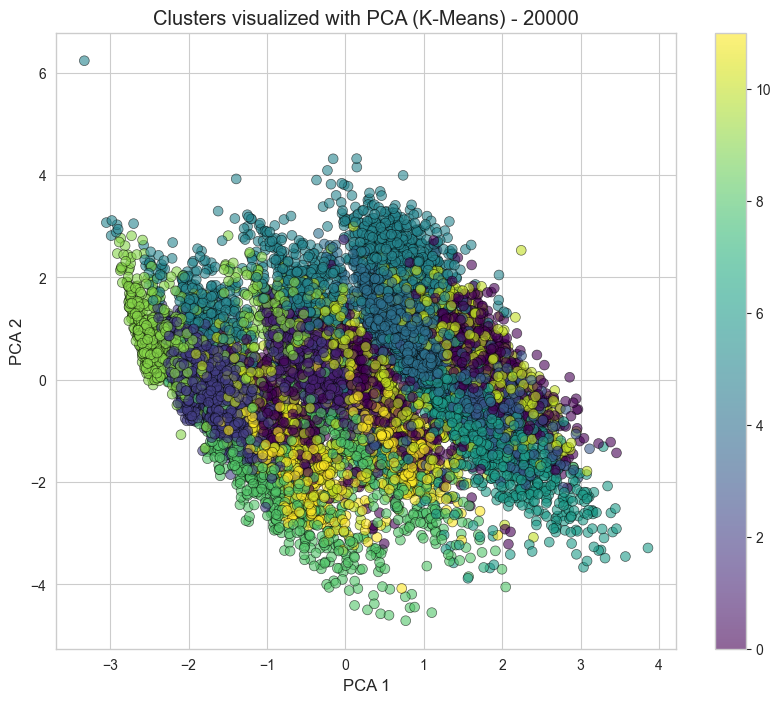

In [51]:
# PCA to reduce dimension to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_reduced)

# Plotting the clusters
plt.figure(figsize = (10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_reduced, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title(f'Clusters visualized with PCA (K-Means) - {n}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

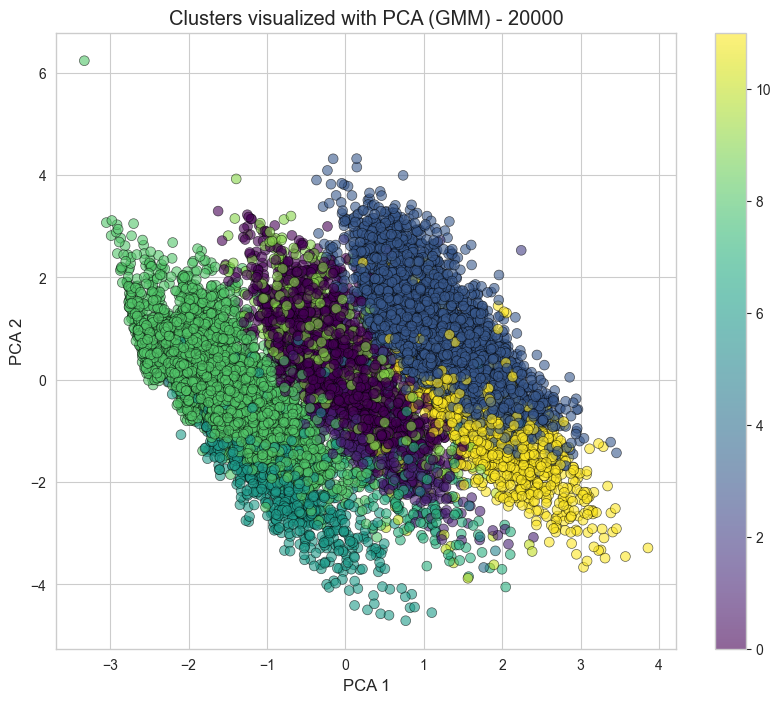

In [52]:
# PCA to reduce dimension to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_reduced)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels_reduced, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title(f'Clusters visualized with PCA (GMM) - {n}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### t-Distributed Stochastic Neighbor Embedding
t-SNE is a non-linear technique particularly well-suited for the visualization of high-dimensional datasets. It can sometimes reveal structures in the data that PCA might not capture. t-SNE focuses on preserving local neighborhoods, potentially revealing more nuanced data structures.

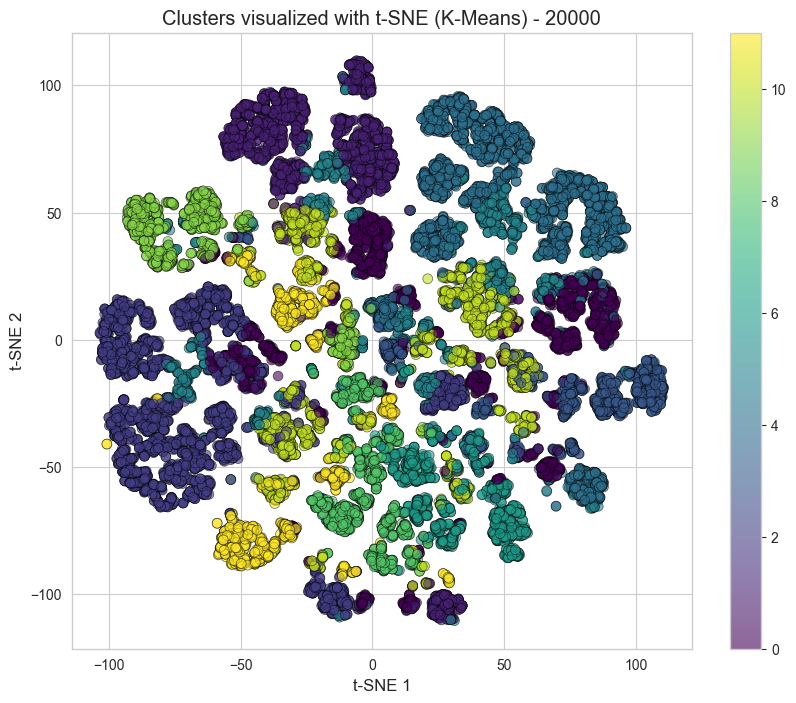

In [53]:
# t-SNE to reduce dimension to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_reduced)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels_reduced, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title(f'Clusters visualized with t-SNE (K-Means) - {n}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

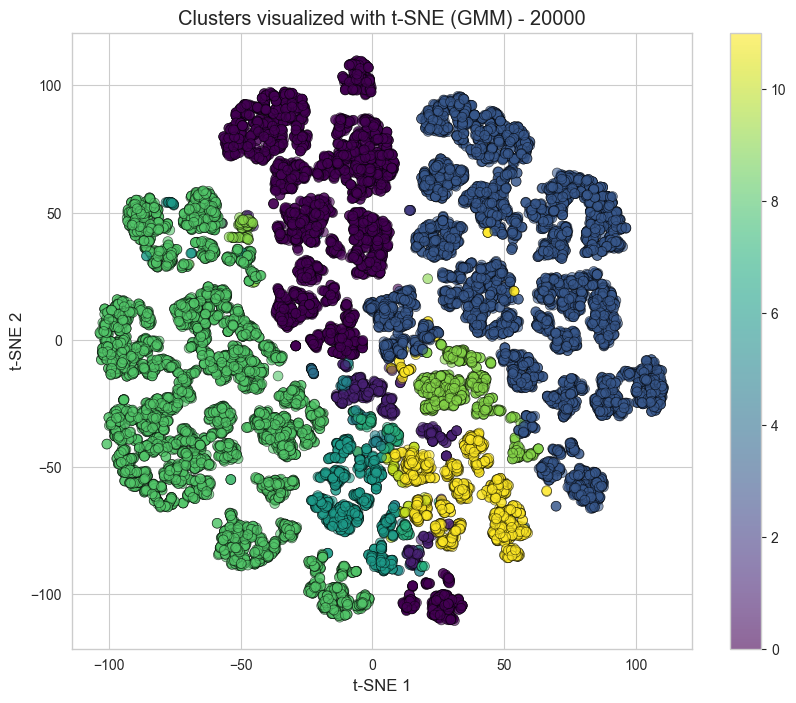

In [54]:
# t-SNE to reduce dimension to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_reduced)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels_reduced, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
plt.title(f'Clusters visualized with t-SNE (GMM) - {n}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

**d)** How do PCA and t-SNE techniques of visulization differ in cluster representation? Which one did a better job at separating clusters from one another, i.e. at identifying subgroups within the data?

**Possible observations:** 
PCA often produces overlapping clusters, which makes it hard to clearly see separate groups. On the other hand, t-SNE shows more distinct, compact clusters. In this case, t-SNE gives a much clearer view of the groups, making it more useful for finding meaningful patterns in the user data.


**e)** **Describe** the differences between plotting clutering methods using different values for `n`. How does this values affect both techniques?

**Possible observations:**
As n increases from 5,000 to 20,000, the visualizations show both benefits and limitations of each method. PCA keeps the overall shape stable but suffers from increasing overlap between clusters, making them harder to distinguish. In contrast, t-SNE continues to clearly separate clusters even with more data, showing consistent and well-defined groupings. However, the plots become denser and slightly harder to interpret visually due to crowding. Overall, increasing n improves the completeness of the picture but challenges readability, especially for PCA.

### Cluster Distribution Analysis.

We examine the distribution of users across clusters, differentiated by sex, using count plots. This analysis can highlight demographic patterns and preferences within each cluster, providing insights into the diversity and composition of user groups.

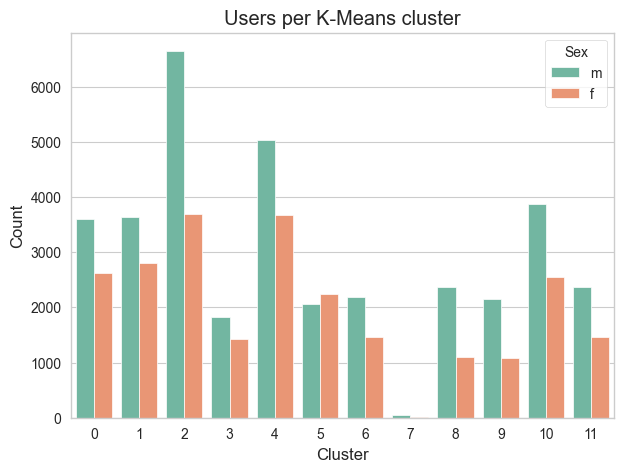

In [55]:
sns.set_style("whitegrid")
color_palette = "Set2"

fig, ax = plt.subplots(figsize=(7, 5))

sns.countplot(data=df, x='kmeans_cluster', ax=ax, hue='sex', palette=color_palette)

ax.set_title('Users per K-Means cluster')
ax.set_ylabel('Count')
ax.set_xlabel('Cluster')

ax.legend(title='Sex')

plt.show()

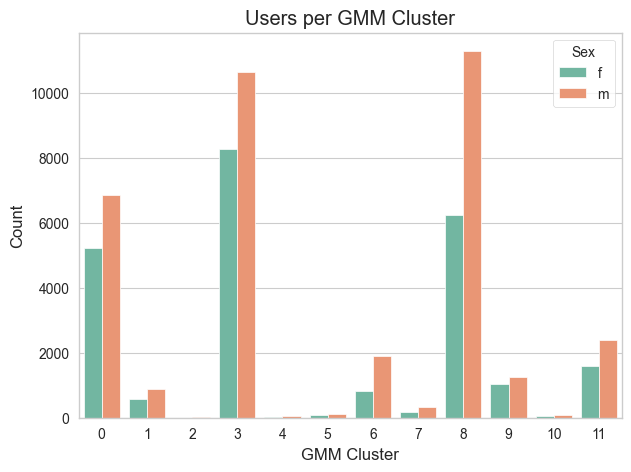

In [56]:
sns.set_style("whitegrid")
color_palette = "Set2" 

fig, ax = plt.subplots(figsize=(7, 5))

sns.countplot(data=df, x='gmm_cluster', ax=ax, hue='sex', palette=color_palette)

ax.set_title('Users per GMM Cluster')
ax.set_ylabel('Count')
ax.set_xlabel('GMM Cluster')

ax.legend(title='Sex')

plt.show()

## Task 3.4 - Usage example. Find match depending on cluster.
Here we demonstrate a practical application of clustering by identifying potential matches for a given user based on cluster membership. This task illustrates how clustering can inform the matchmaking process, leveraging the identified user segments to suggest compatible partners.

**a)** **Select** a profile with `id=42` as a target user and print their profile information.

In [57]:
# Locate user with `id=42` and print their profile information
target_user = df[df['id'] == 42]
print("Profile information for user with id=42:")
print(target_user)

Profile information for user with id=42:
    age  status sex orientation body_type               diet drinks  \
42   30  single   m    straight   average  strictly anything    yes   

                         education ethnicity  height  ...  \
42  graduated from masters program     white    75.0  ...   

                                               essay7 essay8 essay9  id  \
42  seeing live music, performing live music, hang...    NaN    NaN  42   

        city       state likes_dogs likes_cats kmeans_cluster gmm_cluster  
42  berkeley  california      False      False             10           8  

[1 rows x 37 columns]


### Filter Potential Matches.

We filter users who are in the same cluster as the target user, as determined by both K-Means and GMM clustering. We assume that users within the same cluster share certain compatibilities.
Since our target user with `id=42` is a single straight male, we additionaly apply criteria based on `sex =='f'` and `sexual orientation.isin(['straight' or 'bisexual'])` to further refine the pool of potential matches.

In [58]:
users = df_reduced.loc[(df.sex == 'f') &
              (df_reduced.gmm_cluster == df.at[42, 'gmm_cluster']) &
              (df_reduced.kmeans_cluster == df.at[42, 'kmeans_cluster']) &
              (df_reduced.orientation.isin(['straight', 'bisexual']))].index
print(f'So we have found {len(users)} female users in the same cluster.\n')

So we have found 182 female users in the same cluster.



**b)** **Print** the first 10 matched `users` from our dataset

In [59]:
#  print 10 first matched users
print("First 10 matched users:")
print(df_reduced.loc[users].head(10))

First 10 matched users:
     age  status sex orientation body_type               diet     drinks  \
70    25  single   f    straight       NaN                NaN  sometimes   
144   39  single   f    straight       fit    mostly anything  sometimes   
185   44  single   f    straight       fit                NaN  sometimes   
429   23  single   f    straight      thin                NaN  sometimes   
589   25  single   f    straight    skinny    mostly anything  sometimes   
754   25  single   f    straight    skinny  strictly anything  sometimes   
810   37  single   f    straight       fit  strictly anything  sometimes   
859   33  single   f    straight       fit                NaN  sometimes   
878   32  single   f    straight      thin           anything  sometimes   
955   24  single   f    straight      thin    mostly anything  sometimes   

                             education ethnicity  height  ...  \
70   graduated from college/university     white    62.0  ...   
144     g

**c)** **Describe** your observations on compatibility of the user with `id=42` with top-10 matches. What do they have in common?

**Possible observations:** User 42 is a 30-year-old straight male with a master’s degree, average body type, and drinks regularly. He lives in Berkeley, California, and does not like dogs or cats. 

All top-10 matched users are also located in California and do not like pets. All of them drink occasionally and have no strict dietary rules, which aligns fairly well with his lifestyle. While body types differ slightly (slim/fit), the similarities in location, pet preference, education level, ethnicity (mostly white), and lifestyle suggest a reasonable degree of compatibility. 

# Feedback

We're always looking for improvements. Please share your feedback; tell us where you had difficulties or what you’d change to make things better.

**Note:** All feedback will be saved anonymous, so feel free to be open and honest!

**Please write your feedback here:**

## References
- [1] <https://www.kaggle.com/datasets/andrewmvd/okcupid-profiles>
- [2] <https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html>
- [3] <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.CategoricalDtype.html>
- [4] <https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html>
- [5] <https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html>